# **Autoencoders Pipeline**

For Colab, it downloads the data using the following code. 

If you work locally be sure to have the folder *data/*. You can download it from the repo.

In [1]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !rm -rf data
  !mv Capstone-Fall-2020-master/data/ data/
  !mv Capstone-Fall-2020-master/utilities/TS_utils.py /content/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

## Imports

Here some imports of useful packages

In [2]:
!pip -q install -U yellowbrick
!pip -q install scikit-learn-extra

In [3]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from TS_utils import TS_generator, Synthetic_TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians

In [4]:
import tensorflow as tf
import keras
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, InputLayer
import keras.regularizers as reg
from keras.optimizers import Adam

## Model

Here we present the autoencoder model. The final one is composed of a single hidden layer from which we can extract the embedding. 

This architecture is very simple but turned out to be as efficient as more complex ones using LSTM or CNN layers.

In [5]:
class Autoencoder:
    def __init__(self, time_step, n_features=1):
        self.encoder = Sequential()
        self.encoder.add(Dense(20, input_shape=(time_step,)))
                               #kernel_regularizer=reg.l1(0.001),
                               #bias_regularizer=reg.l1(0.001),
                               #activity_regularizer=reg.l1(0.001)) )
        #self.encoder.add(LSTM(10, input_shape=(time_step, n_features), return_sequences=True))
        #self.encoder.add(LSTM(20))

        self.decoder = Sequential()
        #self.decoder.add(Dense(40, activation='relu'))
        self.decoder.add(Dense(time_step))

        self.autoencoder = Model( self.encoder.input, self.decoder(self.encoder.output) )
        self.encoding_model = Model( self.encoder.input, self.encoder.output )

        opt = Adam(learning_rate=0.005)
        self.autoencoder.compile(optimizer=opt, loss='mse')
        print(self.autoencoder.summary())
        #print(self.encoding_model.summary())

    def fit(self, X_train, X_test, epochs=50, verbose=1):
        self.autoencoder.fit(X_train, X_train, batch_size=16, epochs=epochs, shuffle=True,
                             verbose=verbose, validation_data=(X_test, X_test))

    def encode(self, x):
        return self.encoding_model.predict(x)

    def predict(self, x):
        return self.autoencoder.predict(x)


## Preprocess and Train

Here we define the dataset and the preprocessing methods. The parameter SYNTHETIC let the user to choose whether to use synthetic data or real data. It also applies a Discrete Cosine Transform (DCT) to smoothern the timeseries.

<br>

The normalization available are the following:
- MinMax scaling
- Standard scaling
- Median scaling (close to the standard one where mean has been replaced by median and standard deviation by mean absolute deviation)

In [6]:
#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

SYNTHETIC = False
n_ts = 1000

if SYNTHETIC:
  gen = Synthetic_TS_generator(nb_timeseries=2*n_ts, chunk_size=60, noise=False)
  #gen.noise_freq_range = (20,30)
  #gen.build_()
  X = gen.get_array()

  scaler = StandardScaler()
  scaler = MinMaxScaler()
  #scaler = MedianScaler()

  Xscale = scaler.fit_transform(X.T).T
  X_train, X_val = Xscale[:n_ts,:], Xscale[n_ts:,:]
  X_val_mm = (MinMaxScaler().fit_transform(X.T).T)[n_ts:,:]

else:
  gen = TS_generator(nb_timeseries=2*n_ts, chunk_size=60)
  X = gen.get_array()

  lowpass_filter = DCT_lowpass_filter()
  scaler = StandardScaler()
  #scaler = MinMaxScaler()
  #scaler = MedianScaler()

  Xdct = lowpass_filter.fit_transform(X)
  Xscale = scaler.fit_transform(Xdct.T).T

  X_train, X_val = Xscale[:n_ts,:], Xscale[n_ts:,:]
  X_val_mm = (MinMaxScaler().fit_transform(Xdct.T).T)[n_ts:,:]

### Summary of the Autoencoder architecture

In [7]:
model = Autoencoder(time_step=60)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 60)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                1220      
_________________________________________________________________
sequential_1 (Sequential)    (None, 60)                1260      
Total params: 2,480
Trainable params: 2,480
Non-trainable params: 0
_________________________________________________________________
None


### Autoencoder training

In [8]:
model.fit(X_train, X_val, epochs=20, verbose=1)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 0.6315 - val_loss: 0.0819
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0269
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0066
Epoch 4/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 5/20
63/63 [==============================] - 0s 3ms/step - loss: 7.6868e-04 - val_loss: 1.6201e-04
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 1.0351e-04 - val_loss: 2.1335e-05
Epoch 7/20
63/63 [==============================] - 0s 3ms/step - loss: 1.3496e-05 - val_loss: 2.8244e-06
Epoch 8/20
63/63 [==============================] - 0s 3ms/step - loss: 1.6006e-06 - val_loss: 3.1046e-07
Epoch 9/20
63/63 [==============================] - 0s 3ms/step - loss: 1.6364e-07 - val_loss: 2.8303e-08
Epoch 10/20
63/63 [==============================] - 0s 3ms/step - loss: 1.45

## Visualization of the training

Here we present first visualization of the autoencoders results on the validation set.

- The first plot shows an example of a timeseries reconstruction. Visually, the signal is almost perfectly rebuilt.

- The second plot shows the embedding of the first plot with the average embedding among all the dataset. It turns out that the average embedding is close to zero. This is encouraging as we hope to have variation and then a possible influence of the sign.

- The third plot shows the alpha-plot of the embedding. We can see a spiky but spreaded plot around zero.

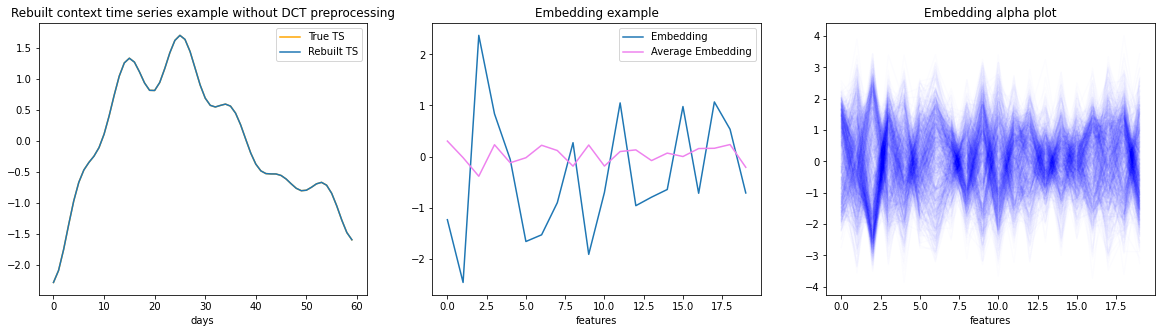

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

idx = 0
x_emb = model.encode(X_val[idx,:].reshape(1,60))[0]
x_rebuilt = model.predict(X_val[idx,:].reshape(1,60))[0]
mean_emb = model.encode(X_val).mean(axis=0)

ax[0].plot(X_val[idx,:], c='orange', label='True TS')
ax[0].plot(x_rebuilt, label='Rebuilt TS')
ax[0].set_xlabel('days')
ax[0].set_title('Rebuilt context time series example without DCT preprocessing')
ax[0].legend()

ax[1].plot(x_emb, label='Embedding')
ax[1].plot(mean_emb, c='violet', label='Average Embedding')
ax[1].set_xlabel('features')
ax[1].set_title('Embedding example')
ax[1].legend()

x_emb = model.encode(X_val)
for i in range(len(X_val)):
    ax[2].plot(x_emb[i,:], alpha=0.01, c='blue')

ax[2].set_xlabel('features')
ax[2].set_title('Embedding alpha plot')

plt.show()

## Clustering

To capture multiscale properties we will perform the clustering on the concatenation of the short-term timeseries (20 most recent data points) and the embedding.

Before clustering we normalize a second time regardless the previous normalization process. Here the chosen normalization process is MinMax scaling.

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from collections import Counter

In [11]:
if SYNTHETIC:
  mean = X[n_ts:].mean(axis=1)
  std =  X[n_ts:].std(axis=1)
  med = np.median(X[n_ts:], axis=1)
  mad = np.median(np.abs(X[n_ts:].T - med).T, axis=1)
else:
  mean = Xdct[n_ts:].mean(axis=1)
  std =  Xdct[n_ts:].std(axis=1)
  med = np.median(Xdct[n_ts:], axis=1)
  mad = np.median(np.abs(Xdct[n_ts:].T - med).T, axis=1)

embedding = model.encode(X_val)
#embedding = ((embedding.T * std) + mean).T
#embedding = (embedding.T * mad) + med
embedding = MinMaxScaler().fit_transform(embedding.T).T
embedding.shape

(1000, 20)

In [12]:
X_cluster = np.concatenate([X_val_mm[:,-20:], embedding], axis=1)
#X_cluster = np.concatenate([X_val[:,40:], embedding], axis=1)
X_cluster.shape

(1000, 40)

### Clustering Techniques

Several techniques can be tried, the usual KMeans turned out te be the most efficient one. In the following cells we will present the different results and how to interpret them.

In [13]:
cl = KMeans(n_clusters=10)
#cl = KMedians(n_clusters=10)
#cl = KMedoids(n_clusters=10, metric='cosine')
y_train_pred = cl.fit_predict(X_cluster)

In [14]:
def visualizer(X_vis, labels, title, xlabel='days'):
  lines = (len(np.unique(y_train_pred)) - 1) // 5 + 1

  fig, ax = plt.subplots(lines, 5, figsize=(22, 5*lines))
  fig.suptitle(title)

  for j in range(5):
    for i in range(lines):
      indices = [k for k,label in enumerate(labels) if label == j + (5*i)]
      #print(indices)
      X_center = np.median(X_vis[indices,:], axis=0)
      for idx in indices:
        ax[i,j].plot(X_vis[idx,:], alpha=0.1, c='blue')
      ax[i,j].plot(X_center, c='orange', linewidth=4)
      ax[i,j].set_xlabel(xlabel)
      ax[i,j].set_title(f'Cluster {j + (5*i)} centroid (n={len(indices)})')

  plt.show()

### On the short time scale

The first plot shows the result of the clustering on the short time scale. For each cluster we display the alpha plot and the average timeseries.

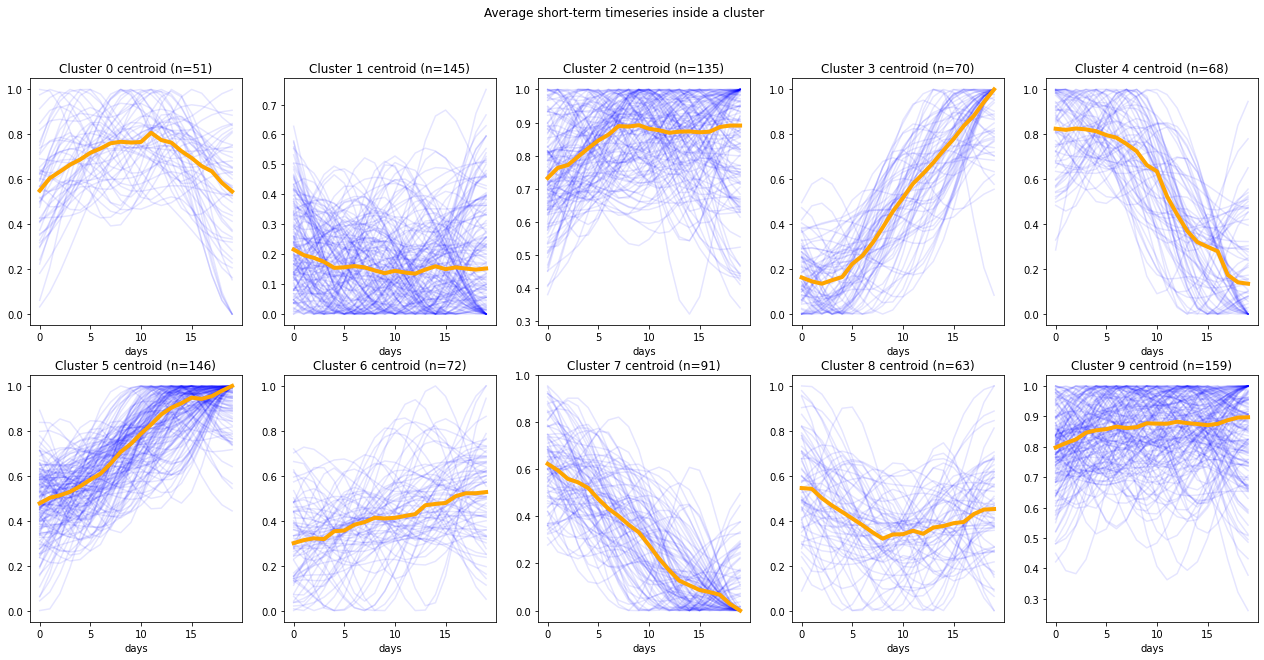

In [15]:
title = 'Average short-term timeseries inside a cluster'
visualizer(X_cluster[:,:20], y_train_pred, title=title)

### On the embeddings

The first plot shows the result of the clustering on the embeddings. For each cluster we display the alpha plot and the average embedding.

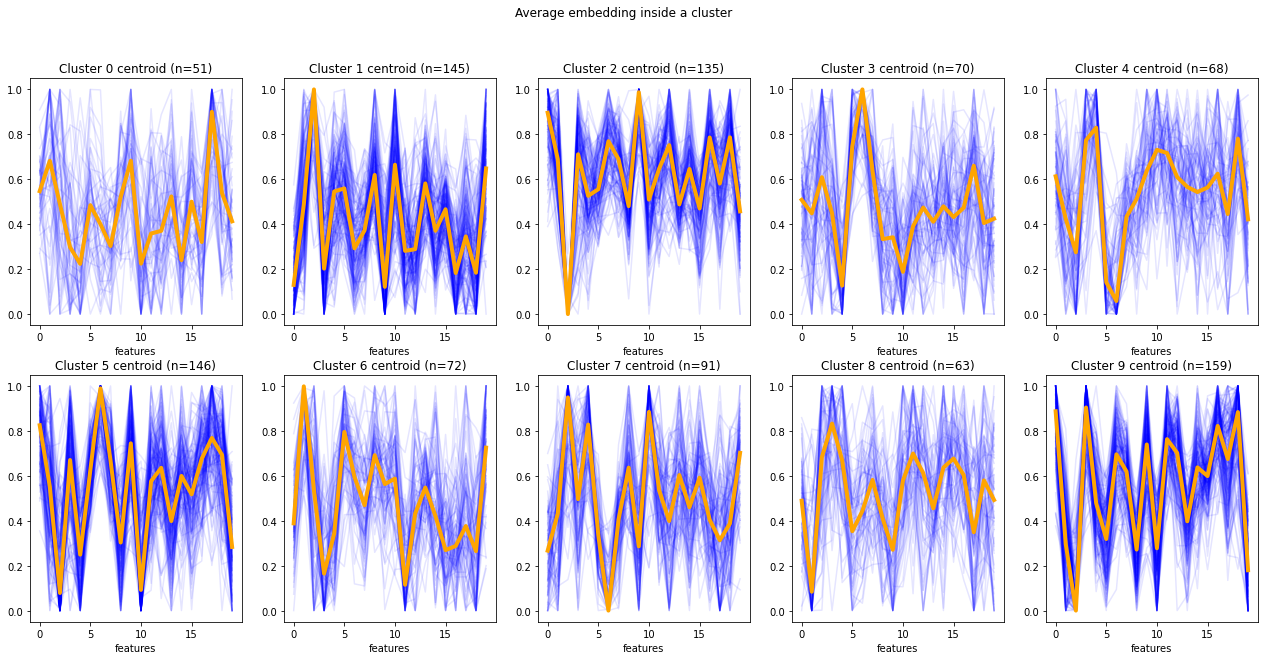

In [16]:
title = 'Average embedding inside a cluster'
visualizer(X_cluster[:,20:], y_train_pred, title=title, xlabel='features')

### On the long time scale

The first plot shows the result of the clustering on the long time scale. For each cluster we display the alpha plot and the average timeseries.

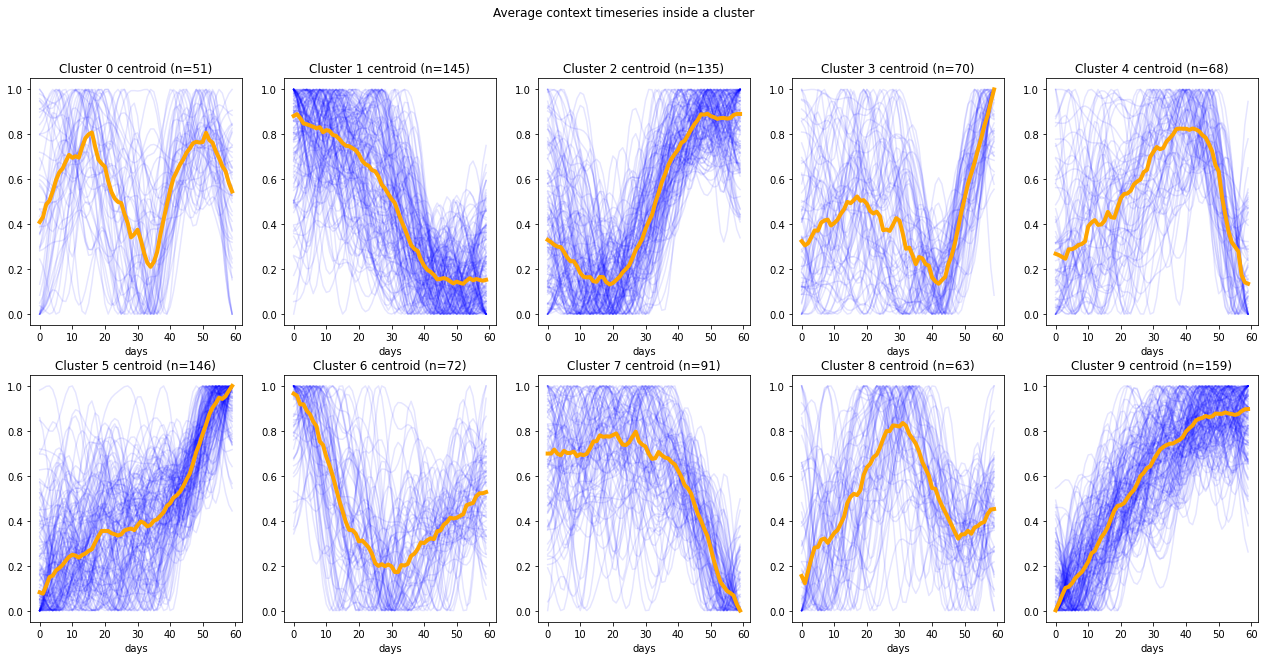

In [17]:
title = 'Average context timeseries inside a cluster'
visualizer(X_val_mm, y_train_pred, title=title)

## Silhouette score

Here we evaluate the autoencoder pipeline using the silhouette score metric. We also provide some visual using different clustering methods. Here we see that KMeans is actually the best one.

In [18]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/lo

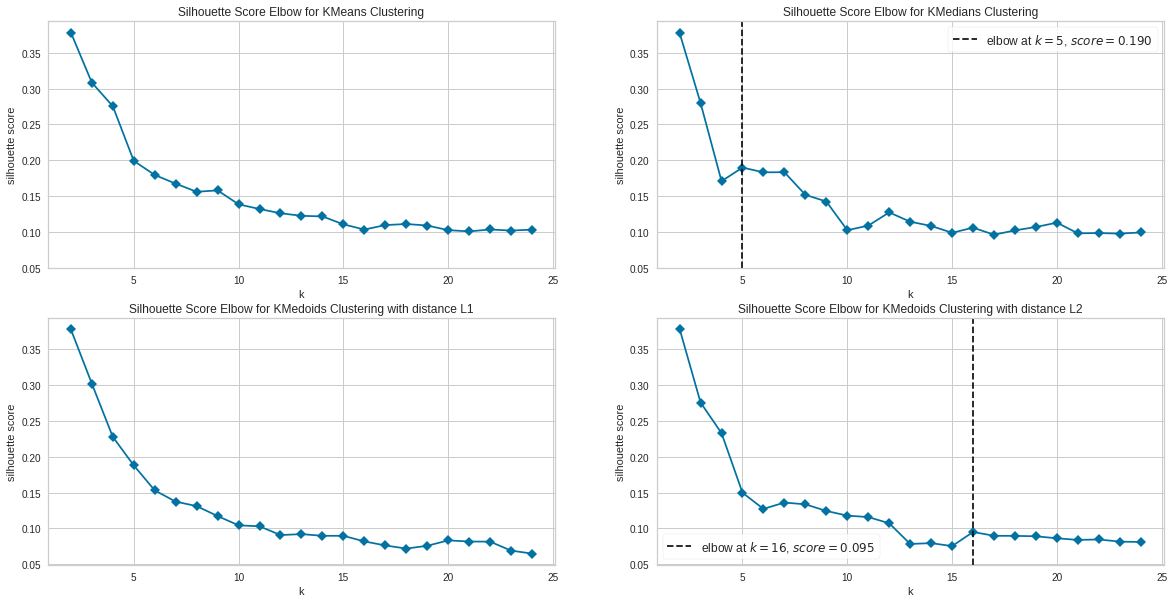

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey='all')
for a in fig.axes:
    a.tick_params(axis='y', which='both', left=True, labelleft=True)

title_medoid = 'Silhouette Score Elbow for KMedoids Clustering with distance '
metric='silhouette'

KElbowVisualizer(KMeans(), k=(2,25), metric=metric, ax=ax[0,0], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedians(), k=(2,25), metric=metric, ax=ax[0,1], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l1'), k=(2,25), metric=metric, ax=ax[1,0], timings=False, title=title_medoid+'L1').fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l2'), k=(2,25), metric=metric, ax=ax[1,1], timings=False, title=title_medoid+'L2').fit(X_cluster).finalize()

plt.show()

In [20]:
from sklearn.metrics import silhouette_score

cl=KMeans(n_clusters=6)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.17383476763746292

### Silhouette score and elbow methods

Here we combine the elbow method and the silhouette score.

In [21]:
score = []
silhouette = []
max_cluster=25

for k in range(2,max_cluster):
  cl = KMeans(n_clusters=k, init='random')
  y_train_pred = cl.fit_predict(X_cluster)
  silhouette.append( silhouette_score(X_cluster, y_train_pred) )
  score.append(cl.inertia_)

Text(0.5, 1.0, 'Silhouette score with KMeans')

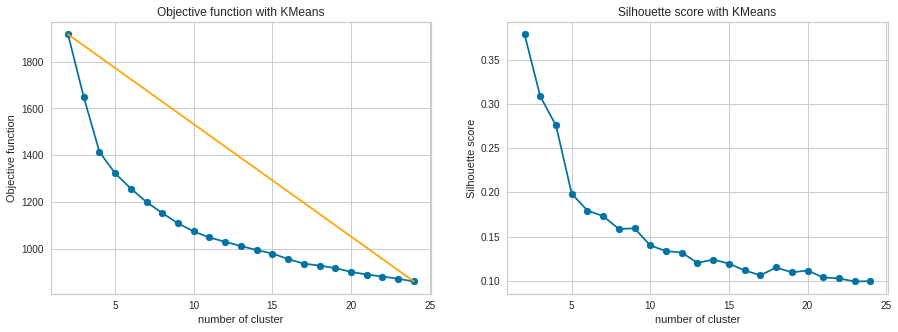

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(list(range(2,max_cluster)), score)
ax[0].scatter(list(range(2,max_cluster)), score)
ax[0].plot([2,max_cluster-1], [score[0], score[-1]], c='orange')
ax[0].set_xlabel('number of cluster')
ax[0].set_ylabel('Objective function')
ax[0].set_title(f'Objective function with KMeans')

ax[1].plot(list(range(2,max_cluster)), silhouette)
ax[1].scatter(list(range(2,max_cluster)), silhouette)
#ax[1].plot([2,max_cluster-1], [silhouette[0], silhouette[-1]], c='orange')
ax[1].set_xlabel('number of cluster')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title(f'Silhouette score with KMeans')

In [23]:
def elbow(score_tab):
  a = (score_tab[-1] - score_tab[0]) / len(score_tab)
  b = score_tab[0]

  elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
  return elb_tab.index(max(elb_tab))

In [24]:
print("Best k for KMeans with objective function:", elbow(score)+2)
print("Best k for KMeans with silhouette score:", elbow(silhouette)+2)

Best k for KMeans with objective function: 8
Best k for KMeans with silhouette score: 6


The following plot display the distribution of silhouette scores of each data point among clusters

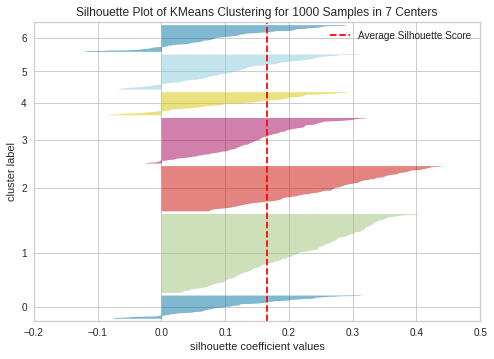

In [25]:
viz_model = KMedians(n_clusters=elbow(silhouette)+2)
viz_model = KMedoids(n_clusters=4, metric='cosine')
viz_model = KMeans(n_clusters=7)

visualizer = SilhouetteVisualizer(viz_model, colors='yellowbrick')
visualizer.fit(X_cluster) 
visualizer.show();

In [26]:
cl = KMedians(n_clusters=elbow(silhouette)+2)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.18772783830596204

In [27]:
from sklearn.metrics import silhouette_samples

def sil_sample_cluster(data, col1, col2, thresh):
  '''
  computes the percentage of silhouette scores about a threshold within each cluster
  (input) data: DataFrame; col1: str refering to cluster column; col2: str refering to silhouette scores column; thresh: float between -1 and 1
  (output) ss_scores; dictionary
  '''
  ss_scores = {}
  for i in range(data[col1].nunique()):
    subs = data[data[col1]==i]
    ss_thresh = subs[subs[col2]>=thresh]
    ss_scores[i] = len(ss_thresh)/len(subs)
  
  return ss_scores

In [28]:
from sklearn.metrics import silhouette_samples

silhouette_scores = silhouette_samples(X_cluster, y_train_pred)

clusters_ss = pd.concat([pd.DataFrame(y_train_pred, columns= ['cluster']), pd.DataFrame(silhouette_scores, columns = ['silhouette_score'])], axis = 1)
clusters_ss.head() 

sil_sample_cluster(clusters_ss, 'cluster', 'silhouette_score', 0.3) #0 for all

{0: 0.3166144200626959,
 1: 0.576271186440678,
 2: 0.08333333333333333,
 3: 0.05263157894736842,
 4: 0.023622047244094488,
 5: 0.0}

## PIP Permutation Entropy

In this part, we use the PIP Permutation Entropy method to measure the multiscale phenomena. 
- We build for 3 PIP point, a histogram of motifs inside a cluster
- We build for 5 PIP point, 3 histograms of motifs inside clusters using a sliding window.

In [29]:
!pip -q install python-fastpip

In [30]:
import numpy 
from fastpip import pip

## these are so help functions 

def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis=0)
    return embed_matrix

def label_motif_general(window):
  s = window
  sort_index = numpy.argsort(s)
  sort_index = [1+i for i in sort_index]
  m='motif_'
  for i in sort_index:
    m = '{}{}'.format(m,i)
  return(m)

def motif_dictionary(x, n=3):
  dict_3_motifs ={}
  for perm in itertools.permutations([i for i in range(1,n+1)]):
    m='motif_' + ''.join(map(str,perm))
    dict_3_motifs[m] = 0

  # find the motifs and add them in a dictionary
  for i in x:
    label = label_motif_general(i)
    dict_3_motifs[label] = dict_3_motifs[label] + 1

  return dict_3_motifs


def transform_to_3_pip(A):
  size = 3
  step = 1
  A = [A[i : i + size] for i in range(0, len(A), step)]
  result = []
  for sub_x in A:
    if len(sub_x) < 3:
      continue
    result.append(sub_x)
  return result

def create_new_list(x):
  new = []
  for i in x:
    new.append(transform_to_3_pip(i))

  flat_list = [item for sublist in new for item in sublist]
  return flat_list

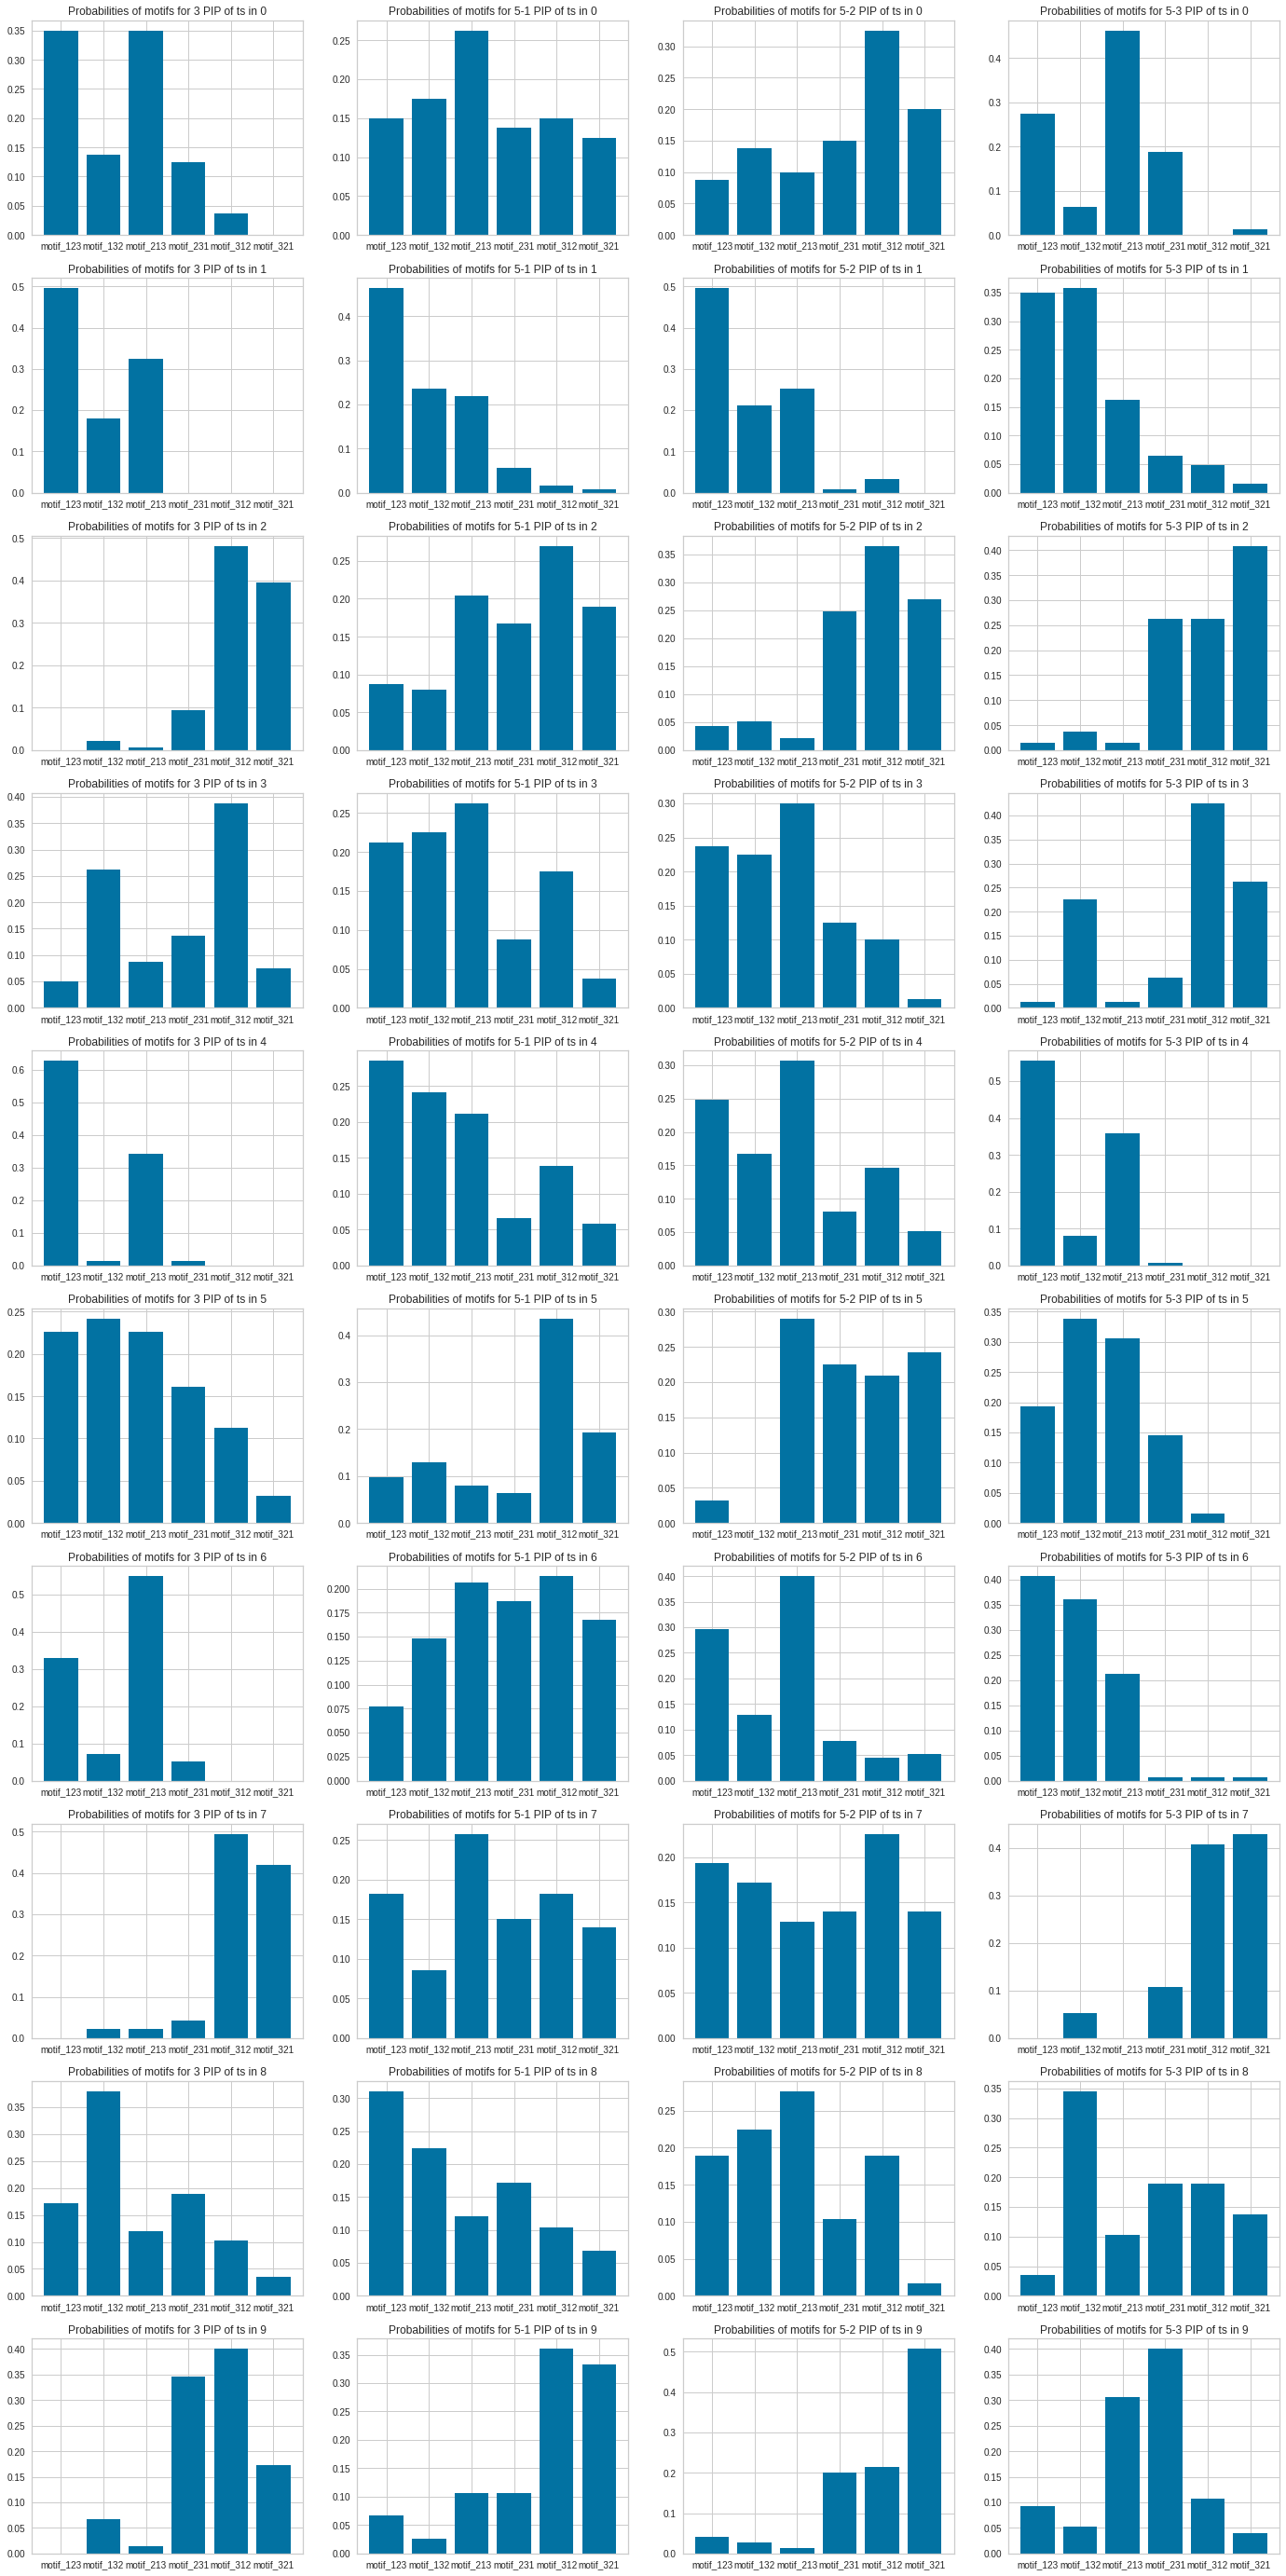

In [31]:
import collections

n_clusters = 10
cl = KMeans(n_clusters=n_clusters)
y_train_pred = cl.fit_predict(X_cluster)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols=4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  
  # reduce dimentions of each ts to 3
  pip_3 = reduce_dimension(X_val[indices,:],3)
  # get 3 dim motifs count
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_3).items()))
  ax[cluster,0].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP of ts in '+str(cluster))

  # reduce dimentions of each ts to 5
  pip_5 = reduce_dimension(np.array(X_val[indices,:]), 5)
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,:3]).items()))
  ax[cluster,1].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,1].title.set_text('Probabilities of motifs for 5-1 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,1:4]).items()))
  ax[cluster,2].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,2].title.set_text('Probabilities of motifs for 5-2 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,2:]).items()))
  ax[cluster,3].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,3].title.set_text('Probabilities of motifs for 5-3 PIP of ts in '+str(cluster))